## ДЗ №3: Рекуррентные нейронные сети.  Обработка естественного языка

### Пожалуйста, заполните имя

In [1]:
STUDENT_NAME = "Kiram Al-Kharba" # For example, Fedor Petriaikin

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
%matplotlib inline

**Не удаляйте клетки из этого jupyter-notebok! Это затруднит проверку!**

В этом задании вам предстоит попробовать различные рекуррентные архитектуры для предсказания временного ряда и написания простейшего чат-бота.


### Часть 1. Предсказание временного ряда

а) Напишите свою реализацию LSTM
<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [3]:
# Кстати, на вход в pytorch-реализацию можно подавать последовательности разной длины.
# См. torch.nn.utils.rnn.pack_padded_sequence() и torch.nn.utils.rnn.pack_sequence()
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, need_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.f = nn.Linear(input_size + hidden_size, hidden_size)
        self.i = nn.Linear(input_size + hidden_size, hidden_size)
        self.g = nn.Linear(input_size + hidden_size, hidden_size)
        self.o = nn.Linear(input_size + hidden_size, hidden_size)
        self.hidden = None
        self.out_layer = nn.Linear(hidden_size, need_size)
        
    # Пропускает через себя последовательность и выдает последний выход
    # X: (seq_len, batch_size, input_size)
    # hidden = (hidden, C): (batch_size, hidden_size)x2 - чтобы начать предсказания с какого-то момента
    # Если None, инициализировать нулями
    # Возвращает out, h, c, где (h, c) - выход и скрытое состояние после последнего элемента
    # out - (seq_len, batch, hidden_size) - выходы каждого слоя
    def LSTMCell(self, x):
        h, c = self.hidden
        h_cat_x = torch.cat((self.hidden[0], x), 1)
        ft = torch.sigmoid(self.f(h_cat_x))
        it = torch.sigmoid(self.i(h_cat_x))
        gt = torch.tanh(self.g(h_cat_x))
        ot = torch.tanh(self.o(h_cat_x))
    
        h *= ft
        h += it * gt
        c = torch.tanh(h) * ot
        
        return (h, c)
        
    def forward(self, X, hidden=None):
        self.batch_size = X.shape[1]
        if hidden == None:
            self.hidden = (torch.zeros((self.batch_size, self.hidden_size), dtype = torch.float32),
                      torch.zeros((self.batch_size, self.hidden_size), dtype = torch.float32))
        else:
            self.hidden = hidden
            
        out = torch.zeros((X.shape[0], self.batch_size, self.hidden_size))
        for i_step, x in enumerate(X):
            self.hidden = self.LSTMCell(x)
            out[i_step] = self.hidden[0]
        
        out = self.out_layer(out)
        h = self.out_layer(self.hidden[0])
        c = self.hidden[1]
        return out, (h, c)

б) Напишите код обучения LSTM на представленных данных

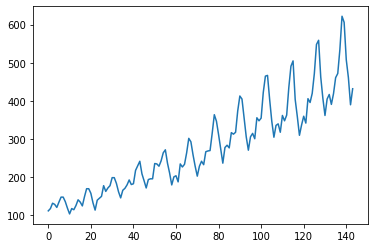

In [4]:
# График (*)
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [5]:
# подготовливаем данные
dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [7]:
# Целевая переменная - сдвинутая последовательность значений входов
# look_back - на сколько смещен test относительно train (seq_len)
# look_forward - сколько нужно предсказать
def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [8]:
# Пример подготовленных данных
look_back = 5
look_forward= 1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
class AirlinePassengersDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [10]:
# Берет данные из dataloader, сам их сдвигает, формируя обучающую выборку
# В качестве функции ошибок возьмите MSELoss, оптимизатор - Adagrad
# В функцию можно добавить дополнительные параметры (например, max_epochs, условия останова...)

from torch.optim.lr_scheduler import StepLR

train_dataset = AirlinePassengersDataset(trainX, trainY)
test_dataset = AirlinePassengersDataset(testX, testY)

train_loader = DataLoader(train_dataset, batch_size=2,
                        shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=12,
                        shuffle=True)

def TrainModel(model, dataloader, epochs = 1, look_back=1, look_forward=1):
    optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
    loss = nn.MSELoss()
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    model.train()
    
    loss_history = []
    for epoch in range(epochs):
        loss_accum = 0 
        for i_step, (x, y) in enumerate(dataloader):
            prediction, *hidden = model.forward(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            scheduler.step()
            loss_accum += loss_value
        loss_history.append(float(loss_accum)/(i_step+1))

    return loss_history

def TestPredict(model, dataloader):
    model.eval()
    for i_step, (x, y) in enumerate(dataloader):
        prediction, *hidden = model.forward(x)
        if i_step == 0:
            res = prediction
        else:
            res = torch.cat((res, prediction), 0)
                
    return res

в) Попробуйте обучить сеть с разными параметрами look_back, look_forward. Также попробуйте использовать различные hidden_size. Выведите предсказания на график (\*). Сделайте вывод.  
*Обратите внимание*: "Классический", однонаправленный LSTM имеет размерность выхода (seq_len, batch, hidden_size). Но иногда нужно "изменить" размерность выхода - для этого можно обучить Linear: hidden_size x need_size  

г) Сравните свой результат и результат с использованием nn.LSTM (на аналогичном числе эпох, hidden_size и т.п.)  

д) Попробуйте использовать nn.GRU. Сравните результаты

In [11]:
model_lstm = nn.Sequential(LSTM(input_size=5, hidden_size=100, need_size=1))
loss_history = TrainModel(model_lstm, train_loader, epochs=10)

/home/kiram/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/kiram/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


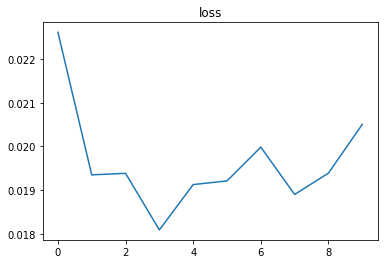

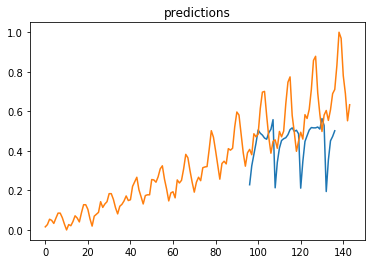

In [12]:
plt.title('loss')
plt.plot(np.arange(10), loss_history)
plt.show()

predictions = TestPredict(model_lstm, test_loader)
predictions = predictions.reshape(predictions.shape[0]).detach().numpy()

plt.title('predictions')
plt.plot(range(96, 96 + 41), predictions)
plt.plot(dataset)
plt.show()

In [13]:
nn_model_lstm = nn.Sequential(nn.LSTM(5, 1, 1))
loss_history= TrainModel(nn_model_lstm, train_loader, epochs=10)

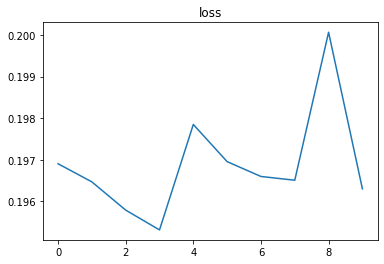

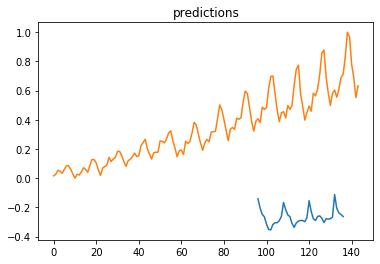

In [14]:
plt.title('loss')
plt.plot(np.arange(10), loss_history)
plt.show()

predictions = TestPredict(nn_model_lstm, test_loader)
predictions = predictions.reshape(predictions.shape[0]).detach().numpy()

plt.title('predictions')
plt.plot(range(96, 96 + 41), predictions)
plt.plot(dataset)
plt.show()

In [15]:
nn_model_gru = nn.Sequential(nn.GRU(5, 1, 1))
loss_history= TrainModel(nn_model_gru, train_loader, epochs=10)

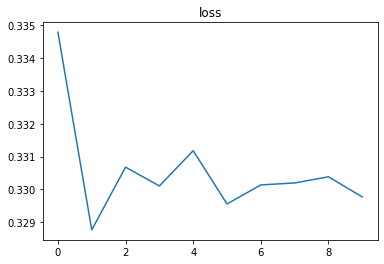

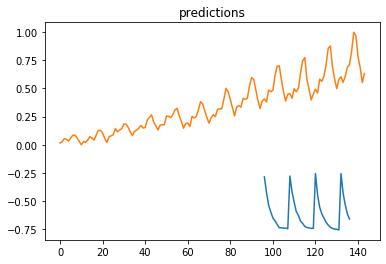

In [16]:
plt.title('loss')
plt.plot(np.arange(10), loss_history)
plt.show()

predictions = TestPredict(nn_model_gru, test_loader)
predictions = predictions.reshape(predictions.shape[0]).detach().numpy()

plt.title('predictions')
plt.plot(range(96, 96 + 41), predictions)
plt.plot(dataset)
plt.show()

### Часть 2. RNN и обработка текстов (Не делал)

В этом задании мы будем использовать файл author-quote.txt

In [20]:
np.random.seed(777)
torch.random.manual_seed(777)

In [21]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]
lines[0]

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

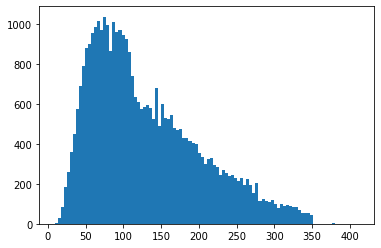

In [22]:
lines_len = []
for l in map(len, lines):
    lines_len.append(l)

plt.hist(lines_len, bins=100);

In [23]:
lines = [l for l in filter(lambda x: len(x) <= 50, lines)]

In [24]:
lines[0]

'Weeds are flowers too, once you get to know them.'

In [29]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        self.all_characters = list(all_characters)+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])
    
vocab = Vocabulary(lines)

In [30]:
listok = vocab.all_characters
a = vocab.encode(listok)

In [31]:
vocab.char_to_id['<go>']

74

In [12]:
a = {x[1]: x[0] for x in enumerate(vocab.all_characters)}
print(a)

{'G': 0, ';': 1, '?': 2, 'I': 3, 'O': 4, '6': 5, 'W': 6, '9': 7, ',': 8, 'D': 9, 'X': 10, '-': 11, 't': 12, 'e': 13, '5': 14, '2': 15, 'o': 16, 'Q': 17, 'n': 18, '1': 19, 'J': 20, 'g': 21, 'a': 22, 'U': 23, 'B': 24, ':': 25, 'K': 26, '7': 27, 'l': 28, 'v': 29, ' ': 30, '0': 31, 'P': 32, '8': 33, "'": 34, 'S': 35, 'm': 36, 'u': 37, 'f': 38, 'q': 39, 'N': 40, 'y': 41, 'r': 42, 'j': 43, 'H': 44, '.': 45, 'A': 46, 'R': 47, 'x': 48, 'z': 49, '$': 50, 'p': 51, '!': 52, 'E': 53, 'b': 54, 'F': 55, 'L': 56, 's': 57, '&': 58, 'T': 59, 'c': 60, 'd': 61, 'Z': 62, 'V': 63, 'M': 64, 'Y': 65, 'k': 66, 'C': 67, '4': 68, '3': 69, 'i': 70, 'h': 71, 'w': 72, '<eos>': 73, '<go>': 74}


In [13]:
# <go>, <eos> - специальные токены начала и конца последовательности, нужны для работы предсказаний
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [14]:
# Для работы pack_padded_sequence
def compose_batch(batch):
    order = np.argsort([-len(x[0]) for x in batch])
    lengths = np.array([len(x[0]) for x in batch])
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [15]:
dataset = Quotes(lines, vocab)
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

KeyError: '<go>'

а) Напишите код класса Oracle

In [26]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    # 1) Генерируем эмбединги входных токенов (из _input), пакуем в pack_padded_sequence, используя lengths
    # 2) Запускаем generator на эмбедингах, пакуем его вывод в pad_packed_sequence
    # 3) Возвращаем предикты (пока без SoftMax) через self.classifier
    def forward(self, _input, lengths):
        ## YOUR CODE HERE
        pass

    # Генерирует последовательность (когда уже обучен). Токены переводим в id с помощью vocab.char_to_id,
    # обратно - с помощью vocab.id_to_char
    # Первый токен - <go>, делаем embeding. Далее generator -- classifier -- softmax.
    # Слово сэмплируем с помощью torch.distributions.Categorical, оно становится новым токеном
    # Повторяем, пока не будет <eos> или не достигнем max_len
    # Возвращаем - сгенерированную строку
    def generate(self, vocab, max_len=100):
        pass

б) Обучите модель. Приведите примеры сгенеррованных предложений

In [27]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

In [28]:
criterion = nn.CrossEntropyLoss(reduction='none')
losses = []

In [29]:
# Чтобы снизить колебания
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [30]:
import progressbar
import tqdm

for epoch in range(1000):
    bar = progressbar.Progr
    essBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

ModuleNotFoundError: No module named 'progressbar'

в) Обучить сеть с LSTM вместо GRU

г) Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох

д) Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

**Спасибо за выполнение заданий!**